# Evaluate user satisfaction &mdash; Customer Support Conversations

This notebook shows you how to retrieve your Customer Support Conversations from Literal and evaluate user satisfaction on this conversational data.  

We leverage OpenAI's API to score the threads with a custom prompt template, and finally plot user satisfaction. 
 
- [Create threads (Optional)](#create-threads)
- [View Thread details](#view-thread-details)
- [Get Threads](#get-threads)
- [Create evaluation prompt template](#create-evaluation-prompt-template)
- [Score threads](#score-threads)
- [Visualize User Satisfaction](#visualize-user-satisfaction)
- [Change Threads tags from `to_score` to `scored`](#change-threads-tags)

## Import the Literal SDK

In [1]:
import os

from openai import AsyncOpenAI
from dotenv import load_dotenv
from literalai import LiteralClient

load_dotenv()

openai_client = AsyncOpenAI()

literalai_client = LiteralClient(batch_size=10)
literalai_client.instrument_openai()

<a id="create-threads"></a>
## Create Threads (Optional)

If you have conversational data &ndash; `Thread` objects in Literal, skip to [View Thread details](#view-thread-details).  

Otherwise, run the next cell to populate a few fictional conversations.

In [2]:
"""
This array contains 8 (fictional) conversational threads which took place between a user
and an assistant. We create those threads directly in Literal via a mimicking application.
"""
conversational_threads = [ 
    [{"role":"user","content":"Hi, I placed an order a few days ago and I was wondering where it is at the moment in the mail."},{"role":"assistant","content":"Hello! I'd be happy to help you with that. Can you please provide me with your order ID so I can check the status for you?"},{"role":"user","content":"Sure, the order ID is 123456789."},{"role":"assistant","content":"I'm sorry, but I couldn't find any information with that order ID. Can you please double check and make sure it's correct?"},{"role":"user","content":"Oh, my mistake. Sorry about that. The correct order ID is 987654321."},{"role":"assistant","content":"Thank you for providing the correct order ID. Let me check that for you... It looks like your package has departed from the shipment facility and is currently in transit. It is currently at a UPS facility in Kentucky. Here is a URL link where you can track the shipment directly from UPS: [link]."},{"role":"user","content":"Awesome, thank you so much for your help! I appreciate it."},{"role":"assistant","content":"You're welcome! If you have any other questions or concerns, feel free to reach out. Have a great day!"}],
    [{"role":"user","content":"Hi, I recently bought a phone from your store, but it has a problem. It keeps turning off automatically, and I\u2019d like to return it."},{"role":"assistant","content":"I'm sorry to hear about the issue you're experiencing with your phone. I'm here to help! To get started, could you please provide me with your product ID?"},{"role":"user","content":"Yes, the product ID is 12345XYZ."},{"role":"assistant","content":"Thank you for that information. Could you also tell me the purchase date of the phone?"},{"role":"user","content":"It was purchased on September 15."},{"role":"assistant","content":"Great, thanks for the information. Lastly, I\u2019ll need the order ID of your purchase to further assist you with the return process."},{"role":"user","content":"The order ID is ABC78910."},{"role":"assistant","content":"Perfect, thank you for providing all the details. I\u2019ve verified the information, and your purchase is eligible for a return. You can send the phone back to us at the following address:\n\n123 Electronics Return Center\n456 Technology Avenue\nGadget City, GC 12345\n\nPlease ensure that the phone is packaged securely and include all the original accessories. Once we receive the phone, we will inspect it and process your refund."},{"role":"user","content":"Thank you for the help."}],
    [{"role":"user","content":"Hello, I'm having trouble with my account. I can't seem to access my purchase history."},{"role":"assistant","content":"I'm sorry to hear that. Could you please provide me with your account information so I can look into this for you?"},{"role":"user","content":"Sure, my username is johndoe123."},{"role":"assistant","content":"Thank you. Let me check on that for you."},{"role":"assistant","content":"I see that your account is active and there doesn't seem to be any issues on our end. Have you tried resetting your password?"},{"role":"user","content":"Yes, I've tried resetting my password multiple times but still can't access my purchase history."},{"role":"assistant","content":"I see. Have you tried clearing your browser cache and cookies? Sometimes that can help resolve login issues."},{"role":"user","content":"Yes, I've tried that as well but it didn't work."},{"role":"assistant","content":"I apologize for the inconvenience. I will escalate this issue to our technical team for further investigation. They will reach out to you shortly."},{"role":"user","content":"I've been dealing with this issue for days now and still no resolution. This is unacceptable."},{"role":"assistant","content":"I understand your frustration, and I assure you that our team will do their best to resolve this as quickly as possible. Thank you for your patience."}], 
    [{"role":"user","content":"Hello, I need help with my order. It was supposed to arrive yesterday, but it hasn't."},{"role":"assistant","content":"I apologize for the delay. Can you please provide me with your order number so I can look into this for you?"},{"role":"user","content":"Sure, my order number is 123456."},{"role":"assistant","content":"Thank you. Let me check on the status of your order."},{"role":"assistant","content":"It looks like your order is still in transit. It may have been delayed due to unforeseen circumstances. I recommend checking the tracking information for the most up-to-date status."},{"role":"user","content":"I already checked the tracking information, but it hasn't been updated in days. Can you find out what's going on?"},{"role":"assistant","content":"I apologize for the inconvenience. Let me escalate this issue to our shipping department and see if we can get more information for you."},{"role":"assistant","content":"I have escalated the issue, and they will reach out to you soon with an update on your order."},{"role":"user","content":"This is unacceptable. I needed this order yesterday, and now I have no idea when it will arrive. I want a refund."},{"role":"assistant","content":"I understand your frustration, and I will make sure to pass along your request for a refund to the relevant department. Thank you for your patience."}], 
    [{"role":"user","content":"Hi, I can't seem to access my account. It keeps saying 'invalid credentials'. Can you help me with that?"},{"role":"assistant","content":"I'm sorry to hear that. Could you please provide me with your username or email associated with the account so I can investigate this issue?"},{"role":"user","content":"My username is sarah123."},{"role":"assistant","content":"Thank you. Let me check on your account."},{"role":"assistant","content":"It seems like there might be an issue with the password. Have you tried resetting your password to see if that resolves the login problem?"},{"role":"user","content":"I tried resetting my password, but it's still not working."},{"role":"assistant","content":"I'm sorry to hear that. Have you tried using a different browser or clearing your cache and cookies? Sometimes that can help in resolving login issues."},{"role":"user","content":"I'm not sure how to do that. Can you explain it to me in simpler terms?"},{"role":"assistant","content":"Certainly. In your web browser, go to the settings and look for an option to clear browsing data. Select the option to clear cache and cookies, and then try logging in again."},{"role":"user","content":"I'm sorry, I don't understand. I'll ask a friend for help instead. Bye."}], 
    [{"role":"user","content":"Hello, I'm having trouble with the mobile app. It keeps crashing every time I try to open it."},{"role":"assistant","content":"I apologize for the inconvenience. Can you please provide me with details about your device and which version of the app you are using?"},{"role":"user","content":"I have an iPhone X and I believe I'm using the latest version of the app."},{"role":"assistant","content":"Thank you for that information. Let me check on this issue for you."},{"role":"assistant","content":"It seems that there might be a compatibility issue with the latest iOS update. I recommend checking for app updates or reinstalling the app to see if that resolves the crashing problem."},{"role":"user","content":"I've already tried updating and reinstalling the app, but it's still crashing. I don't know what to do."},{"role":"assistant","content":"I'm sorry to hear that. Since you've already tried the common troubleshooting steps, I recommend contacting Apple support for further assistance with this issue on your device."},{"role":"user","content":"I thought you could help me with this issue. I guess I'll have to figure it out on my own. Goodbye."}], 
    [{"role":"user","content":"Hi, I'm experiencing issues with my account. I can't seem to access certain features."},{"role":"assistant","content":"I'm sorry to hear that. Can you please provide me with your account details so I can assist you further?"},{"role":"user","content":"My account email is example@email.com."},{"role":"assistant","content":"Thank you. Let me see what's going on with your account."},{"role":"assistant","content":"It looks like there are no account restrictions or issues on our end. Have you tried logging out and logging back in to see if that resolves the issue?"},{"role":"user","content":"Yes, I've tried that multiple times, and I still can't access certain features."},{"role":"assistant","content":"I apologize for the inconvenience. Let me escalate this issue to our technical support team for further investigation. They will reach out to you soon with a resolution."},{"role":"user","content":"This issue has been going on for too long now. I need this problem fixed immediately."},{"role":"assistant","content":"I understand your urgency, and I will make sure to prioritize this issue with our technical team. Thank you for your patience and understanding."},{"role":"user","content":"Wait a minute... Are you a real person or a robot? I need actual human support to help me with this issue."}], 
    [{"role":"user","content":"Hi, I'm having trouble with my internet connection. It keeps dropping out randomly."},{"role":"assistant","content":"I'm sorry to hear that. Let's troubleshoot this together. Have you tried restarting your modem?"},{"role":"user","content":"Yes, I've tried that already. It didn't help."},{"role":"assistant","content":"Okay, let's check some settings on your router. Can you access the router settings page?"},{"role":"user","content":"Yes, I can access the settings page."},{"role":"assistant","content":"Great. Let's check the signal strength and see if there are any interference issues."},{"role":"user","content":"I see the signal strength is strong, but I'm still experiencing dropouts."},{"role":"assistant","content":"Did you try resetting the network settings on your devices to see if that resolves the issue?"}]
]

# Agent logic to implement below.
@literalai_client.step(type="run", name="Agent logic - Scheduling & calls to tools")
def agent_logic():
    with literalai_client.step(type="tool", name="Query ERM database"):
        pass
    with literalai_client.step(type="llm", name="Call LLM"):
        pass

@literalai_client.thread(tags=["to_score"])
def run_conversation(thread_messages):
    literalai_client.get_current_thread().name = thread_messages[0]["content"]
    for message in thread_messages:
        if message["role"] == "user":
            literalai_client.message(type="user_message", content=message["content"], name="User")
        else:
            agent_logic()
            literalai_client.message(type="assistant_message", content=message["content"], name="Customer Support Assistant")

for thread_messages in conversational_threads:
    run_conversation(thread_messages)

literalai_client.flush()

## View Thread details

The below screen capture shows how the first thread appears in Literal, with the user and the assistant going back and forth on the issue at hand.  

You should see an equivalent flow if you have actual conversational data in your project. 

![Thread details.png](img/threads-view.gif)

## Get Threads

We are now set to get the threads to score.  

From the **Threads** table, you can filter on the threads with the `to_score` tag, and then click "Export":  

![Threads table](img/threads-to-score.gif)

The **Export Threads** window pops up and provides the exact filters to pass to the `get_threads` API.  
Copy and paste below to fetch your selected threads via the SDK.  

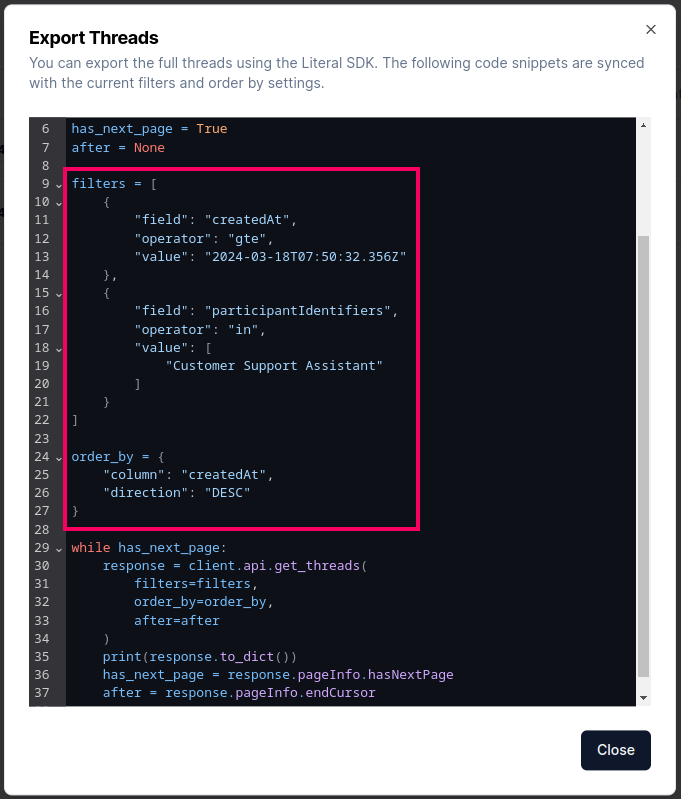

With our fictional threads, we will simply filter down on the `to_score` tag:

In [3]:
threads = literalai_client.api.get_threads(filters=[{
    "field": "tags",
    "operator": "in",
    "value": ["to_score"]
}], step_types_to_keep=["user_message", "assistant_message"]).data

print(f"Number of fetched threads: {len(threads)}")

Number of fetched threads: 20


<a id="create-evaluation-prompt-template"></a>
## Create evaluation prompt template

In [4]:
template_messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content": """
Context:

You are an advanced language model tasked with evaluating a conversation between a customer support agent and a user. Your goal is to assess the agent's effectiveness in addressing and solving the user's request or problem. The conversation will be provided to you, and based on your analysis, you will assign a score that reflects the agent's performance.

Instructions:

1. Read the Conversation: Carefully read the provided dialogue between the customer support agent and the user. Pay attention to the details of the user's request or problem, the responses from the agent, and the overall flow of the conversation.

2. Evaluate Based on Key Criteria:
   - Effectiveness of Response: Evaluate the relevance and accuracy of the information provided by the agent. Consider if the responses were clear and helpful towards solving the user's problem.
   - Efficiency: Consider how efficiently the agent worked towards a resolution. This includes the timeliness of responses and whether the conversation progressed towards a solution without unnecessary detours.
   - Resolution: Determine if the conversation ended with the user's issue being resolved or with a clear path towards resolution.

3. Assign a Score: Based on your evaluation, assign a score to the agent's performance using the following scale:
   - 1 (Poor): The agent was not able to provide a solution to the user.
   - 2 (Fair): The agent showed some understanding of the issue and gave a workaround to the user, but nothing more; The issue remained.
   - 3 (Good): The agent understood the user's issue and provided helpful information.
   - 4 (Very Good): The agent demonstrated a strong understanding of the problem, responded with relevant and effective solutions. The user's issue was nearly or fully resolved.
   - 5 (Excellent): The agent provided highly effective and efficient responses, and resolved the user's problem completely.

After evaluating the conversation based on the criteria above, provide your score as an integer between 1 and 5. Only answer with a single character in the following value {1, 2, 3, 4, 5}.
Don't provide explanations, only the single integer value.

Conversation:

{{#thread_messages}}
{{role}}: {{content}}
{{/thread_messages}}

Scoring Output:

"""
    }
]

prompt = literalai_client.api.get_or_create_prompt(name="Satisfaction Evaluation prompt", template_messages=template_messages)

<a id="score-threads"></a>
## Score threads

### Define helper to build thread messages

In [5]:
def build_messages(thread):
    """
        Format the steps' messages to OpenAI's format, as 
        [{ "role": , "content": }]
    """
    messages = []
    for step in thread.steps:
        messages.append({
            "role": step.type.split('_')[0],
            "content": step.output["content"]
        })

    return messages

### Score using OpenAI

To ensure we get an integer user satisfaction score, we rely on [Outlines](https://outlines-dev.github.io/outlines/) to guarantee the generated output is in the 1 to 5 range.

In [7]:
import json

thread_scores = []
categories = ["1", "2", "3", "4", "5"]

for thread in threads:
    messages = prompt.format_messages(thread_messages=build_messages(thread))

    completion = await openai_client.chat.completions.create(
        messages=messages,
        model="gpt-4o-mini",
        response_format={
            "type": "json_schema",
            "json_schema": {
              "name": "user_satisfaction",
              "strict": True,
              "schema": {
                "type": "object",
                "properties": {
                  "satisfaction": {
                    "type": "string",
                    "enum": categories,
                    "oneOf": [
                        {
                          "const": "1",
                          "description": "Poor: The agent was not able to provide a solution to the user.",
                        },
                        {
                          "const": "2",
                          "description": "Fair: The agent showed some understanding of the issue and gave a workaround to the user, but nothing more; The issue remained.",
                        },
                        {
                          "const": "3",
                          "description": "Good: The agent understood the user's issue and provided helpful information.",
                        },
                        {
                          "const": "4",
                          "description": "Very Good: The agent demonstrated a strong understanding of the problem, responded with relevant and effective solutions. The user's issue was nearly or fully resolved.",
                        },
                        {
                          "const": "5",
                          "description": "Excellent: The agent provided highly effective and efficient responses, and resolved the user's problem completely.",
                        },
                     ],
                  }
                },
                "additionalProperties": False,
                "required": [
                  "satisfaction"
                ]
              }
            }
        }
    )
    
    structured_output = json.loads(completion.choices[0].message.content)
    thread_scores.append(structured_output["satisfaction"])

<a id="visualize-user-satisfaction"></a>
## Visualize User Satisfaction

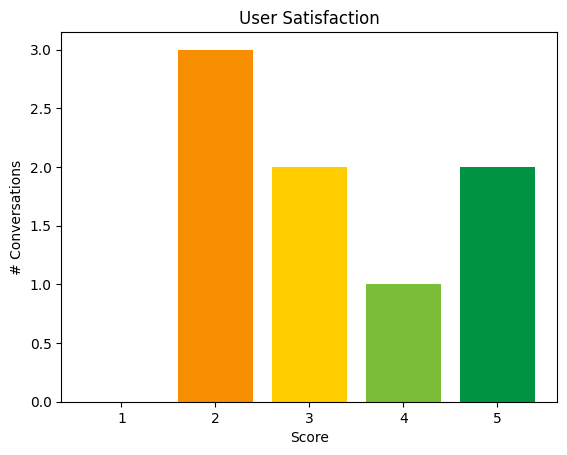

In [11]:
import matplotlib.pyplot as plt

color = ['#f24610', '#f88f00', '#ffcd00', '#7cbd38', '#009342']
values = [thread_scores.count(c) for c in categories]

fig, ax = plt.subplots()

ax.bar(categories, values, color=color)
ax.set_xlabel("Score")
ax.set_ylabel("# Conversations")

plt.title("User Satisfaction")
plt.show()

<a id="change-threads-tags"></a>
## Change Threads tags from `to_score` to `scored`

In [12]:
for thread in threads:
    literalai_client.api.update_thread(id=thread.id, tags=["scored"])

And the threads we had to score show up as `scored` !

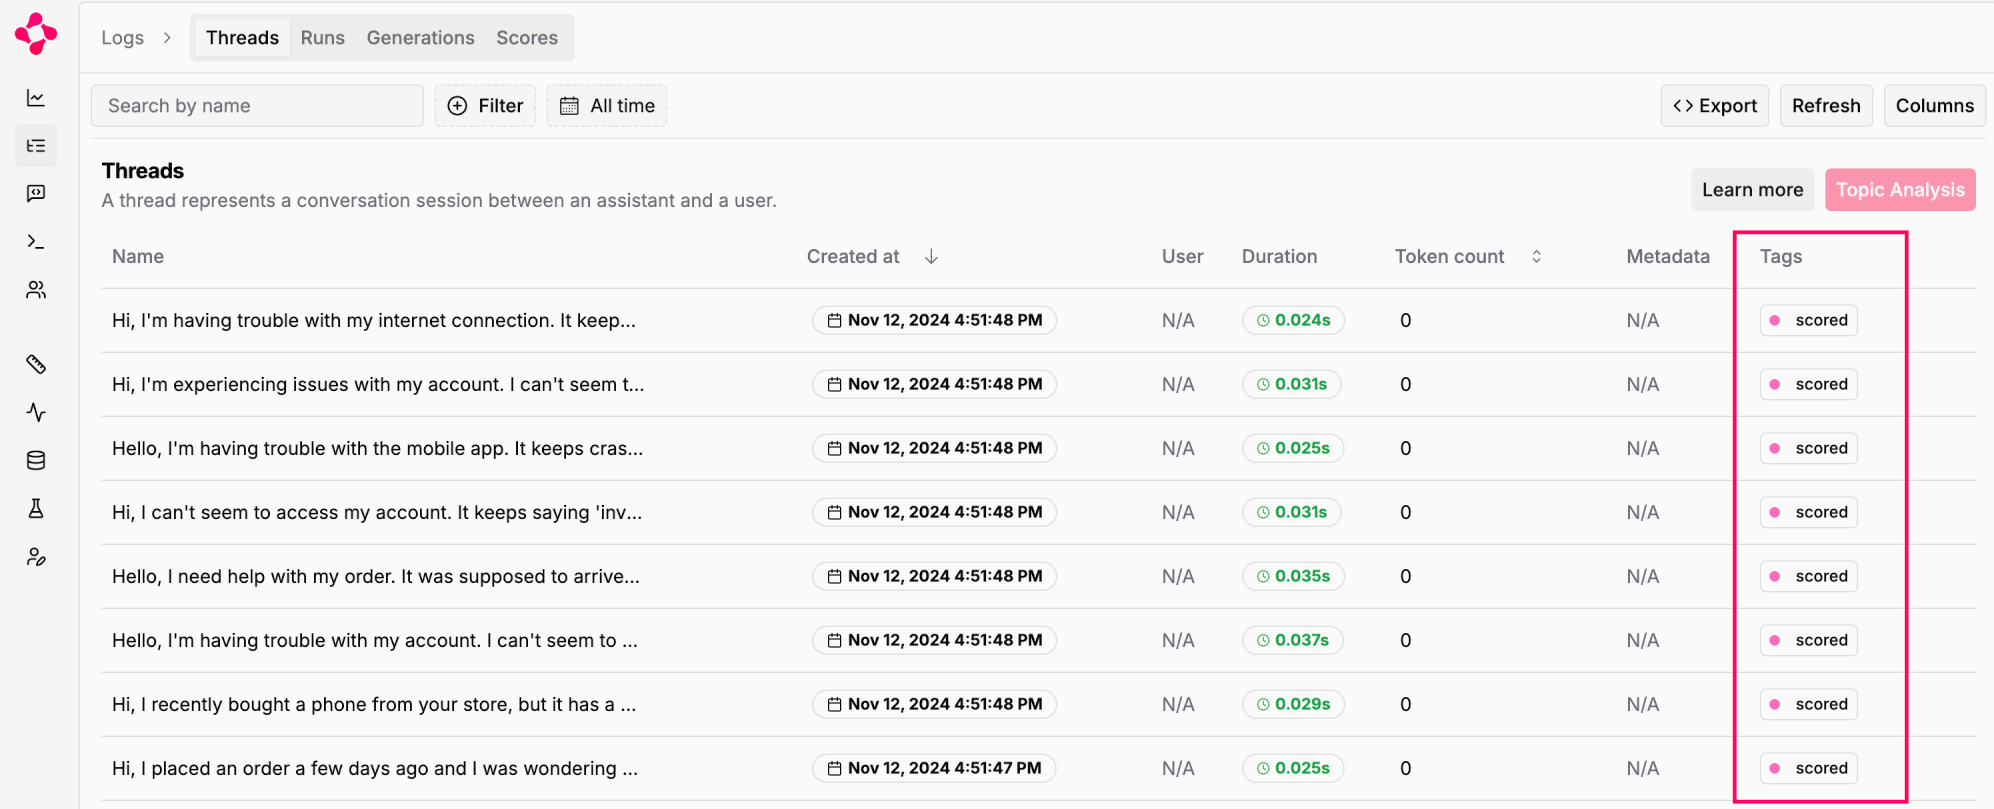